In [20]:
import pandas as pd

# Loading the CSVs
train_df = pd.read_csv("../data/raw/train.csv", parse_dates=['date'])
stores_df = pd.read_csv("../data/raw/stores.csv")
transactions_df = pd.read_csv("../data/raw/transactions.csv", parse_dates=['date'])
oil_df = pd.read_csv("../data/raw/oil.csv", parse_dates=['date'])
holidays_df = pd.read_csv("../data/raw/holidays_events.csv", parse_dates=['date'])
family_meta_df = pd.read_csv("../data/raw/family_metadata.csv")

In [21]:
# Merging external metadata
train_df = train_df.merge(stores_df, on='store_nbr', how='left')
train_df = train_df.merge(transactions_df, on=['date', 'store_nbr'], how='left')
train_df = train_df.merge(family_meta_df, left_on='family', right_on='item_family', how='left')
train_df = train_df.drop(columns=['item_family'])

train_df = train_df.merge(oil_df, on='date', how='left')
train_df['dcoilwtico'].interpolate(method='linear', inplace=True)

# Demand intensity
train_df['sales_per_transaction'] = train_df['sales'] / train_df['transactions']



C:\Users\rezzt\AppData\Local\Temp\ipykernel_24484\2024698126.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['dcoilwtico'].interpolate(method='linear', inplace=True)


In [22]:
train_df

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,transactions,is_perishable,shelf_life_days,dcoilwtico,sales_per_transaction
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,Quito,Pichincha,D,13,NaN,0,365,NaN,NaN
1,1,2013-01-01,1,BABY CARE,0.000,0,Quito,Pichincha,D,13,NaN,0,180,NaN,NaN
2,2,2013-01-01,1,BEAUTY,0.000,0,Quito,Pichincha,D,13,NaN,0,365,NaN,NaN
3,3,2013-01-01,1,BEVERAGES,0.000,0,Quito,Pichincha,D,13,NaN,0,120,NaN,NaN
4,4,2013-01-01,1,BOOKS,0.000,0,Quito,Pichincha,D,13,NaN,0,365,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,Quito,Pichincha,B,6,2155.0,1,7,47.57,0.203310
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Quito,Pichincha,B,6,2155.0,1,3,47.57,0.071718
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,Quito,Pichincha,B,6,2155.0,1,5,47.57,1.122844
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Quito,Pichincha,B,6,2155.0,0,365,47.57,0.056148


## Exploring missing transactions

In [23]:
# Finding the Total rows where sales = 0 and transactions = NaN

missing_tx_with_zero_sales = train_df[
    (train_df['sales'] == 0) & (train_df['transactions'].isna())
]

print(f"🧾 Total rows where sales = 0 and transactions = NaN: {len(missing_tx_with_zero_sales)}")
missing_tx_with_zero_sales.head()


🧾 Total rows where sales = 0 and transactions = NaN: 242536


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,transactions,is_perishable,shelf_life_days,dcoilwtico,sales_per_transaction
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,0,365,NaN,NaN
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,0,180,NaN,NaN
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,0,365,NaN,NaN
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,0,120,NaN,NaN
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,0,365,NaN,NaN


In [24]:
# Finding missing transaction with zero sales by store
missing_by_store = missing_tx_with_zero_sales.groupby('store_nbr').size().sort_values(ascending=False)
print(missing_by_store.head())

# Finding missing transaction with zero sales by family
missing_by_family = missing_tx_with_zero_sales.groupby('family').size().sort_values(ascending=False)
print(missing_by_family.head())


store_nbr
52    51678
22    33377
42    31754
21    30828
29    26674
dtype: int64
family
BOOKS                         7448
BABY CARE                     7435
HOME APPLIANCES               7402
SCHOOL AND OFFICE SUPPLIES    7391
LIQUOR,WINE,BEER              7384
dtype: int64


In [25]:
# Creating diagnostic flags incase the model gives poor predictions where logs were imputed
train_df['transactions_missing'] = train_df['transactions'].isna().astype(int)
train_df['zero_sales'] = (train_df['sales'] == 0).astype(int)


In [26]:
# How often both occur together
overlap_count = train_df[
    (train_df['transactions_missing'] == 1) & (train_df['zero_sales'] == 1)
].shape[0]

print(f"Rows with both transactions missing AND zero sales: {overlap_count}")


Rows with both transactions missing AND zero sales: 242536


In [27]:
# Checking if this phenomenon occurs on specific dates
overlap_by_date = train_df[
    (train_df['transactions_missing'] == 1) & (train_df['zero_sales'] == 1)
].groupby('date').size().sort_values(ascending=False)

print("Dates with highest overlap:")
print(overlap_by_date.head(10))


Dates with highest overlap:
date
2016-01-01    1753
2013-01-01    1749
2017-01-01    1749
2015-01-01    1749
2014-01-01    1716
2016-01-03     318
2013-06-19     295
2013-07-14     264
2013-07-08     264
2013-07-09     264
dtype: int64


In [28]:
# Crosstab check for Transactions missing vs 0 Sales
pd.crosstab(train_df['transactions_missing'], train_df['zero_sales'], margins=True)


zero_sales,0,1,All
transactions_missing,,,
0,2058510,696594,2755104
1,3248,242536,245784
All,2061758,939130,3000888


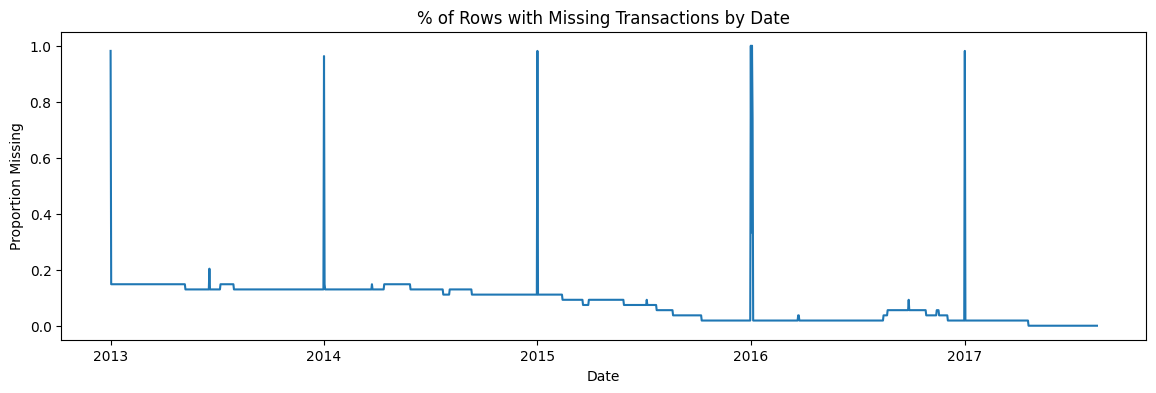

In [29]:
# Heatmap of missing transactions over time
import seaborn as sns
import matplotlib.pyplot as plt

missing_by_day = train_df.groupby('date')['transactions_missing'].mean()

plt.figure(figsize=(14, 4))
sns.lineplot(data=missing_by_day)
plt.title("% of Rows with Missing Transactions by Date")
plt.ylabel("Proportion Missing")
plt.xlabel("Date")
plt.show()


#### Over 240K rows show missing transactions alongside zero sales, mostly concentrated on the first day of each year, likely due to system-wide logging gaps or holidays.  
#### This systemic anomaly was validated via crosstabs and date-wise analysis, and should be handled with cautious imputation or exclusion in downstream modeling.


## Prepping

In [30]:
# Dates with full missing transaction spikes from analysis
anomalous_dates = ["2013-01-01", "2014-01-01", "2015-01-01", "2016-01-01", "2017-01-01"]

# Dropping those rows
train_df = train_df[~train_df['date'].isin(anomalous_dates)].reset_index(drop=True)
print(f"Dropped rows from known anomalous dates: {anomalous_dates}")


C:\Users\rezzt\AppData\Local\Temp\ipykernel_24484\522854384.py:5: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  train_df = train_df[~train_df['date'].isin(anomalous_dates)].reset_index(drop=True)


Dropped rows from known anomalous dates: ['2013-01-01', '2014-01-01', '2015-01-01', '2016-01-01', '2017-01-01']


In [31]:
# For remaining transactions NaNs, we assume stores follow trends and patterns. Therefore Forward + Backward Fill by Store

train_df['transactions'] = train_df.groupby('store_nbr')['transactions'].transform(
    lambda x: x.fillna(method='ffill').fillna(method='bfill')
)

# Fallback: Global median fill
train_df['transactions'] = train_df['transactions'].fillna(train_df['transactions'].median())


C:\Users\rezzt\AppData\Local\Temp\ipykernel_24484\1476551548.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  lambda x: x.fillna(method='ffill').fillna(method='bfill')


In [32]:
train_df

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,transactions,is_perishable,shelf_life_days,dcoilwtico,sales_per_transaction,transactions_missing,zero_sales
0,1782,2013-01-02,1,AUTOMOTIVE,2.000,0,Quito,Pichincha,D,13,2111.0,0,365,93.14,0.000947,0,0
1,1783,2013-01-02,1,BABY CARE,0.000,0,Quito,Pichincha,D,13,2111.0,0,180,93.14,0.000000,0,1
2,1784,2013-01-02,1,BEAUTY,2.000,0,Quito,Pichincha,D,13,2111.0,0,365,93.14,0.000947,0,0
3,1785,2013-01-02,1,BEVERAGES,1091.000,0,Quito,Pichincha,D,13,2111.0,0,120,93.14,0.516817,0,0
4,1786,2013-01-02,1,BOOKS,0.000,0,Quito,Pichincha,D,13,2111.0,0,365,93.14,0.000000,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2991973,3000883,2017-08-15,9,POULTRY,438.133,0,Quito,Pichincha,B,6,2155.0,1,7,47.57,0.203310,0,0
2991974,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Quito,Pichincha,B,6,2155.0,1,3,47.57,0.071718,0,0
2991975,3000885,2017-08-15,9,PRODUCE,2419.729,148,Quito,Pichincha,B,6,2155.0,1,5,47.57,1.122844,0,0
2991976,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Quito,Pichincha,B,6,2155.0,0,365,47.57,0.056148,0,0


## Continuing merging

In [33]:
# Adding Time Features
train_df['date'] = pd.to_datetime(train_df['date'])
train_df['day_of_week'] = train_df['date'].dt.dayofweek          # Monday = 0, Sunday = 6
train_df['month'] = train_df['date'].dt.month
train_df['week'] = train_df['date'].dt.isocalendar().week.astype(int)
train_df['year'] = train_df['date'].dt.year
train_df['is_weekend'] = train_df['day_of_week'].isin([5, 6]).astype(int)
train_df['is_month_start'] = train_df['date'].dt.is_month_start.astype(int)
train_df['is_month_end'] = train_df['date'].dt.is_month_end.astype(int)

# Merging Oil Prices
oil_df = pd.read_csv("../data/raw/oil.csv", parse_dates=["date"])
oil_df = oil_df.set_index("date").resample("D").mean().ffill().reset_index()
train_df = pd.merge(train_df, oil_df, on='date', how='left')
train_df.rename(columns={'dcoilwtico_y': 'dcoilwtico'}, inplace=True)

# Merging and Cleaning Holiday Info
holidays_df = pd.read_csv("../data/raw/holidays_events.csv", parse_dates=["date"])

# Removing transferred holidays (i.e., those that were moved away)
holidays_df = holidays_df[~((holidays_df['transferred'] == True) & (holidays_df['type'] != 'Transfer'))]

# Removing redundant 'Transfer' entries, keeping only the final celebrated date
holidays_df = holidays_df[holidays_df['type'] != 'Transfer']

# Focusing only on National and Local holidays (work holidays, weekends, etc. leads to confusion)
holidays_df = holidays_df[holidays_df['locale'].isin(['National', 'Local'])]

# Marking any holiday date as holiday = 1 for simplification
holidays_df['is_holiday'] = 1

# De-duplicating in case of overlaps
holiday_flags = holidays_df[['date', 'is_holiday']].drop_duplicates()

# Merging with main df
train_df = train_df.merge(holiday_flags, on='date', how='left')
train_df['is_holiday'] = train_df['is_holiday'].fillna(0).astype(int)

In [34]:
train_df

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,...,zero_sales,day_of_week,month,week,year,is_weekend,is_month_start,is_month_end,dcoilwtico,is_holiday
0,1782,2013-01-02,1,AUTOMOTIVE,2.000,0,Quito,Pichincha,D,13,...,0,2,1,1,2013,0,0,0,93.14,0
1,1783,2013-01-02,1,BABY CARE,0.000,0,Quito,Pichincha,D,13,...,1,2,1,1,2013,0,0,0,93.14,0
2,1784,2013-01-02,1,BEAUTY,2.000,0,Quito,Pichincha,D,13,...,0,2,1,1,2013,0,0,0,93.14,0
3,1785,2013-01-02,1,BEVERAGES,1091.000,0,Quito,Pichincha,D,13,...,0,2,1,1,2013,0,0,0,93.14,0
4,1786,2013-01-02,1,BOOKS,0.000,0,Quito,Pichincha,D,13,...,1,2,1,1,2013,0,0,0,93.14,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2991973,3000883,2017-08-15,9,POULTRY,438.133,0,Quito,Pichincha,B,6,...,0,1,8,33,2017,0,0,0,47.57,1
2991974,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Quito,Pichincha,B,6,...,0,1,8,33,2017,0,0,0,47.57,1
2991975,3000885,2017-08-15,9,PRODUCE,2419.729,148,Quito,Pichincha,B,6,...,0,1,8,33,2017,0,0,0,47.57,1
2991976,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Quito,Pichincha,B,6,...,0,1,8,33,2017,0,0,0,47.57,1


In [35]:
# Checking all columns for missing values and their counts

missing_summary = train_df.isnull().sum()
missing_summary[missing_summary > 0].sort_values(ascending=False)

sales_per_transaction    237039
dtype: int64

In [36]:
# Filling missing sales_per_transaction with 0 where sales are 0

train_df['sales_per_transaction'].fillna(0, inplace=True)

C:\Users\rezzt\AppData\Local\Temp\ipykernel_24484\1842422956.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['sales_per_transaction'].fillna(0, inplace=True)


In [37]:
print("Unique values in 'is_holiday':", train_df['is_holiday'].unique())
print("Unique values in 'is_weekend':", train_df['is_weekend'].unique())
print("Date Range:", train_df['date'].min(), "to", train_df['date'].max())
print("Sample oil prices:", train_df['dcoilwtico'].dropna().sample(5))


Unique values in 'is_holiday': [0 1]
Unique values in 'is_weekend': [0 1]
Date Range: 2013-01-02 00:00:00 to 2017-08-15 00:00:00
Sample oil prices: 512679     102.34
2498034     45.20
1069174     95.78
2497519     45.20
466233     104.70
Name: dcoilwtico, dtype: float64


In [38]:
# Saving cleaned trained_df
train_df.to_csv("../data/processed/cleaned_train.csv", index=False)
print("Final cleaned dataset saved to data/processed/cleaned_train.csv")


Final cleaned dataset saved to data/processed/cleaned_train.csv
